# 2P fly holder calibration

Measure the tradeoff as we push a fly closer to the center of two perpendicular display panels. We'll define two functions: 1) fov, to measure the total subtended angle of the display as a function of the fly's distance to the center and 2) resolution, to measure the subtended angle of the closest pixel, representing the minimum resolution of the display. These two must trade off, but it's possible that there's an optimal distance to keep a sufficient resolution (the display is 4k!) and maximize the fov. At one extreme, if the fly is at the center, it's unable to resolve the closest pixel (resolution = 0). At the other extreme (for our purposes), the fly has 180 deg FOV.

In [1]:
# import libraries and define useful functions
import numpy as np
from matplotlib import pyplot as plt

def FOV_v(dist=1, height=150, **kwargs):
    """Calculate the vertical subtended angle of each panel for a given distance.
    
    Parameters
    ----------
    dist : float, default=1
        The distance from the center or intersection of displays.
    height : float, default=1
        The height of the display.

    Returns
    -------
        Field of view in degrees.    
    """
    if isinstance(dist, np.ndarray):
        assert np.all(dist <= max_dist), "dist(={dist.max()}) can't be greater than max_dist(={max_dist})"
    else:
        assert dist <= max_dist, "dist(={dist}) can't be greater than max_dist(={max_dist})"
    half_angle = np.arctan2(height, 2 * dist)
    return np.rad2deg(2 * half_angle)

def FOV_h(dist=1, max_dist=1, **kwargs):
    """Calculate the subtended angle for a given distance to the center.
    
    Parameters
    ----------
    dist : float, default=1
        The distance from the center or intersection of displays.
    max_dist : float, default=1
        The maximum working distance from the center. This represents the distance
        where the FOV goes below 180 degs. 

    Returns
    -------
        Field of view in degrees.    
    """
    if isinstance(dist, np.ndarray):
        assert np.all(dist <= max_dist), "dist(={dist.max()}) can't be greater than max_dist(={max_dist})"
    else:
        assert dist <= max_dist, "dist(={dist}) can't be greater than max_dist(={max_dist})"
    return np.rad2deg(2 * (np.pi - np.arctan2(max_dist, max_dist - dist)))

def resolution(dist=1, max_dist=1, pixel_width=.1, **kwargs):
    """Calculates the spatial resolution.
    
    Resolution is calculated based on the subtended angle of the closest pixel. 
    So this equation is based on finding the distance of the closest pixel and 
    the known width of those pixels.

    Parameters
    ----------
    dist : float, default=1
        The distance from the center or intersection of displays.
    max_dist : float, default=1
        The maximum working distance from the center. This represents the distance
        where the FOV goes below 180 degs. 
    pixel_width : float, default=.1
        The pixel width in the same units as dist and max_dist.

    Returns
    -------
        The Nyquist limit based on the subtended angle of the closest pixel.
    """
    if isinstance(dist, np.ndarray):
        assert np.all(dist <= max_dist), "dist(={dist.max()}) can't be greater than max_dist(={max_dist})"
    else:
        assert dist <= max_dist, "dist(={dist}) can't be greater than max_dist(={max_dist})"
    angle = np.arcsin((pixel_width * np.sqrt(2))/(2 * dist))
    angle = np.rad2deg(angle)
    return (4 * angle) ** -1

# Phone Example
Let's try using real values given the phone's dimensions and resolution. We're planning to use one of the foldable phones with holocube, setting up 1 panel for each half of the folded display. The fly will be placed along the center of the display, but we're unsure of how far to place the fly. Above, you can see that while resolution drops off linearly as a function of distance, field of view is more quadratic. I want to plot the actual tradeoff of each to find the distance that maximizes the FOV without sacrificing too much spatial resolution.

# Dimensions

The panel is approximately 128/2=64 mm wide, consisting of 1768/2=884 pxls, and 150 mm tall, consisting of 2208 pxls. The maximum distance is the hypotenus of a 45-45-90 triangle where two sides equal the panel width. Thus, max_dist = sqrt(2) * side length.

![Samsung Galaxy Fold 3](../samsung_fold3_dimensions.png)

C:\Users\johnp\AppData\Local\Temp\ipykernel_12064\503832747.py:72: RuntimeWarning: divide by zero encountered in divide
  angle = np.arcsin((pixel_width * np.sqrt(2))/(2 * dist))
C:\Users\johnp\AppData\Local\Temp\ipykernel_12064\503832747.py:72: RuntimeWarning: invalid value encountered in arcsin
  angle = np.arcsin((pixel_width * np.sqrt(2))/(2 * dist))


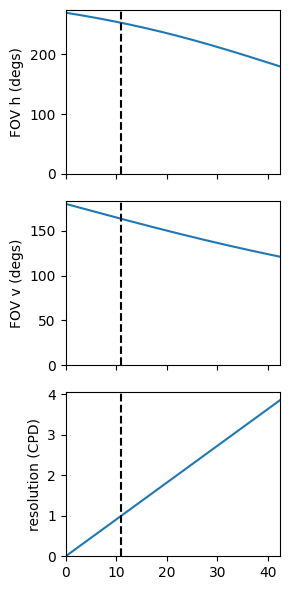

to keep a resolution of at least 1 CPD, keep the fly 10.999438818457406 mm away from the center. This generates a FOV of 253.05771073397034 degs horizontally and 163.31305619936697 vertically
if the pivot is placed halfway, resolution is 1.9305176991441493 CPD and FOV is 233.0842106629666 horizontally and 148.38362354699453 vertically.


In [8]:
panel_width = 60 # mm
panel_height = 150 # mm
max_dist = panel_width * np.sqrt(2)/2
num_pixels_h = 884
pixel_width = panel_width/num_pixels_h
num_pixels_v = 2208
pixel_height = panel_height/num_pixels_v
# grab a bunch of distances less than max_dist
dists = np.linspace(0, max_dist, 1000)
# plot the FOV and resolution as a function of distance
fig, axes = plt.subplots(nrows=3, figsize=(3, 6), sharex=True)
yvals = []
for func, ax, ylbl in zip([FOV_h, FOV_v, resolution], axes, ['FOV h (degs)', 'FOV v (degs)', 'resolution (CPD)']):
    ys = func(dist=dists, max_dist=max_dist, pixel_width=pixel_width, height=panel_height)
    yvals += [ys]
    ax.plot(dists, ys)
    ax.set_ylabel(ylbl)
    ax.set_ylim(0)
# find the lowest distance that keeps resolution >= 1 CPD
min_dist = dists[yvals[2] > 1].min()
min_ind = np.where(dists == min_dist)[0][0]
for ax in axes:
    ax.axvline(min_dist, color='k', linestyle='--')
ax.set_xlim(0, max_dist)
fig.tight_layout()
plt.show()
# print some important configurations:
# the large FOV calibration:
print(f"to keep a resolution of at least 1 CPD, keep the fly {min_dist} mm away from the center. This generates a FOV of {yvals[0][min_ind]} degs horizontally and {yvals[1][min_ind]} vertically")
# the balanced calibration:
min_dist = dists[dists > (max_dist/2)].min()
min_ind = np.where(dists == min_dist)[0][0]
print(f"if the pivot is placed halfway, resolution is {yvals[2][min_ind]} CPD and FOV is {yvals[0][min_ind]} horizontally and {yvals[1][min_ind]} vertically.")

In [13]:
# calculate the frustum of the screen from two postitions: 1) max_dist and 2) max_dist/2
# re-calculate this relative to a near distance of .1
near_dist = .1
# actually, this is the distance to the screen's far edge, which is the hypotenuse of the distance that I want
dist = panel_width / 2.0

for dist in [dist]:
    # get the left, right, bottom, and top of the screen
    left = -panel_width/2
    right = panel_width/2
    bottom = -panel_height/2
    top = panel_height/2
    # using the principle of similar triangles, find the new left, right, bottom, and top
    new_left = left * near_dist/dist
    new_right = right * near_dist/dist
    new_bottom = bottom * near_dist/dist
    new_top = top * near_dist/dist
    print(f"at a distance of {dist} mm, the screen is a frustum with the following dimensions:")
    print(f"left: {new_left}, right: {new_right}, bottom: {new_bottom}, top: {new_top}\n")
    


at a distance of 30.0 mm, the screen is a frustum with the following dimensions:
left: -0.1, right: 0.1, bottom: -0.25, top: 0.25



In [12]:
dist

30.0

In [4]:
import pyperclip
pyperclip.copy(new_left)
# wait for input to copy the next value
input("Press Enter to copy the next value...")
pyperclip.copy(new_right)
# wait for input to copy the next value
input("Press Enter to copy the next value...")
pyperclip.copy(new_bottom)
# wait for input to copy the next value
input("Press Enter to copy the next value...")
pyperclip.copy(new_top)

In [5]:
print(panel_width, panel_height)

64 150


In [6]:
max_dist

45.254833995939045